In [1]:
import scanpy as sc

In [3]:
adata = sc.read_10x_h5("/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5")

print(adata)

AnnData object with n_obs × n_vars = 68255 × 0
    var: 'gene_ids', 'feature_types', 'genome'


In [4]:
import h5py

with h5py.File("/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5", "r") as f:
    print(list(f.keys()))

['matrix']


sc.read_10x_h5()로 불러왔을 때 , 68255 (유전자 열이 없음)
h5py로 열어보니깐 key가 matrix 하나만 존재


이 파일은 10x Genomics 공식 형식 (h5, key=’matrix’, ‘features’, ‘barcodes’ 등) 아닌, TISCH2에서 제공하는 커스텀 hdf5 파일이다.

### anndata 객체로 변환

현재 키가 matrix 하나라서, 그 내부를 열어야 한다.

data → 실제 count 값 (sparse matrix 형태)

indices, indptr, shape → CSR 포맷 정보

barcodes → 세포 ID

features 또는 genes → 유전자 ID

In [15]:

with h5py.File("/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5", "r") as f:
    print(list(f["matrix"].keys()))

['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']


In [6]:
import scipy.sparse as sp
import numpy as np
import anndata as ad

In [11]:
file = "/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5"


with h5py.File(file, "r") as f:
    grp = f["matrix"]
    
    data = grp["data"][:]
    indices = grp["indices"][:]
    indptr = grp["indptr"][:]
    shape = grp["shape"][:]

    # CSC 포맷으로 읽기 (gene × cell)
    X = sp.csc_matrix((data, indices, indptr), shape=shape)

    # 바코드 / 유전자 이름 확인
    barcodes = [x.decode("utf-8") for x in grp["barcodes"][:]]
    
    if "name" in grp["features"]:
        genes = [x.decode("utf-8") for x in grp["features"]["name"][:]]
    elif "gene_names" in grp["features"]:
        genes = [x.decode("utf-8") for x in grp["features"]["gene_names"][:]]
    else:
        genes = [x.decode("utf-8") for x in grp["features"]["id"][:]]
    
    gene_ids = [x.decode("utf-8") for x in grp["features"]["id"][:]]

# AnnData 객체 생성 (행=세포, 열=유전자로 transpose 필요)
adata = ad.AnnData(X.transpose())
adata.obs_names = barcodes
adata.var_names = genes
adata.var["gene_ids"] = gene_ids

In [16]:
print(adata)

AnnData object with n_obs × n_vars = 68255 × 24410
    var: 'gene_ids'


### Scanapy 에서 QC 유전자 그룹 식별

In [17]:
# mitochondrail genes, "MT-"
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
# QC metric 계산
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo","hb"],
    inplace=True,
    log1p=False,
    percent_top=None
)

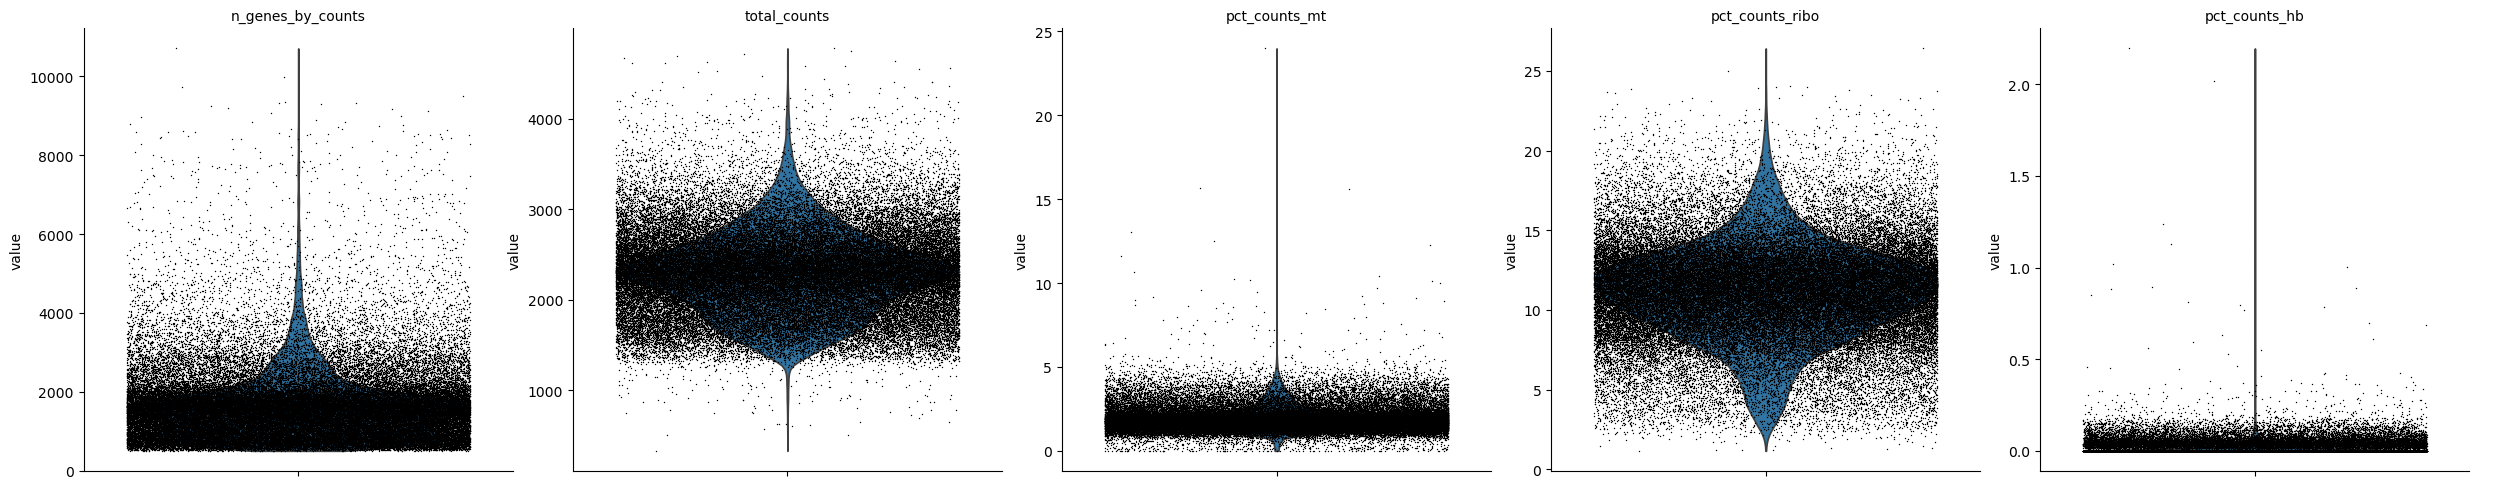

In [19]:
# QC violin plot
sc.pl.violin(
    adata,
    ["n_genes_by_counts","total_counts","pct_counts_mt","pct_counts_ribo","pct_counts_hb"],
    jitter=0.4,
    multi_panel=True
)

저품질 세포 제거

In [25]:
# 필터링
adata_qc = adata[
    (adata.obs["n_genes_by_counts"] > 200) &
    (adata.obs["n_genes_by_counts"] < 5000) &
    (adata.obs["pct_counts_mt"] < 20),
    :
].copy()


print(f"QC 전 세포 수 : {adata.n_obs}")
print(f"QC 후 세포 수 : {adata_qc.n_obs}")

QC 전 세포 수 : 68255
QC 후 세포 수 : 67603


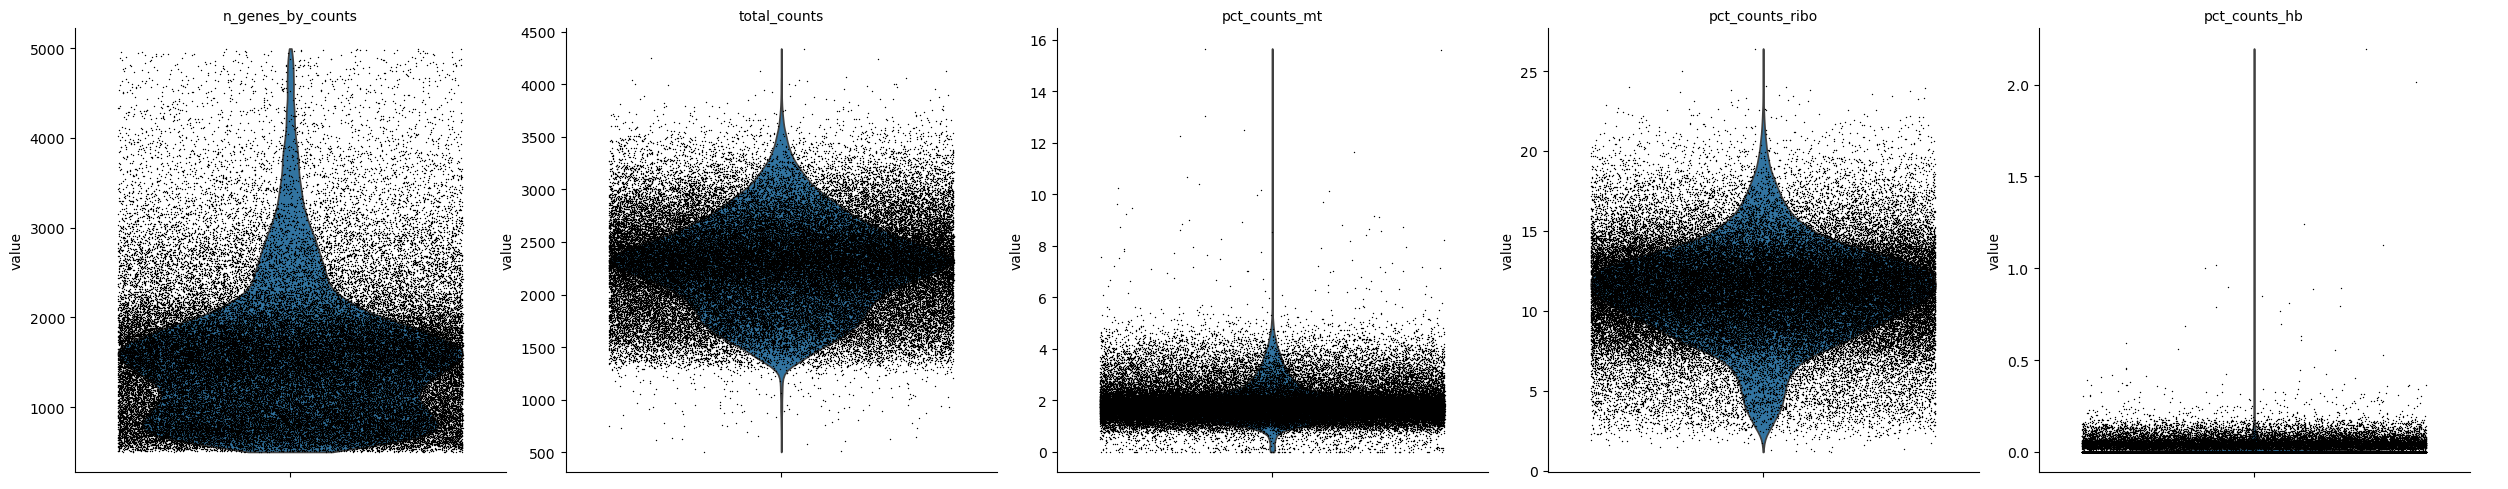

In [26]:
sc.pl.violin(
    adata_qc,
    ["n_genes_by_counts","total_counts","pct_counts_mt","pct_counts_ribo","pct_counts_hb"],
    jitter=0.4,
    multi_panel=True
)

미토콘트드리아 유전자 발현 비율 상위 5개

In [27]:
print(adata.obs["pct_counts_mt"].head())

GSM4952953@AAACGGGCAGCTCGAC-1    1.382725
GSM4952953@AAAGCAAAGCGAAGGG-1    1.428726
GSM4952953@AAATGCCCAGAGTGTG-1    2.127167
GSM4952953@AACCATGTCTTGTACT-1    1.559541
GSM4952953@AACTCCCTCGAATGGG-1    1.659165
Name: pct_counts_mt, dtype: float32


총 발현량과 유전자 수를 산점도로 시각화

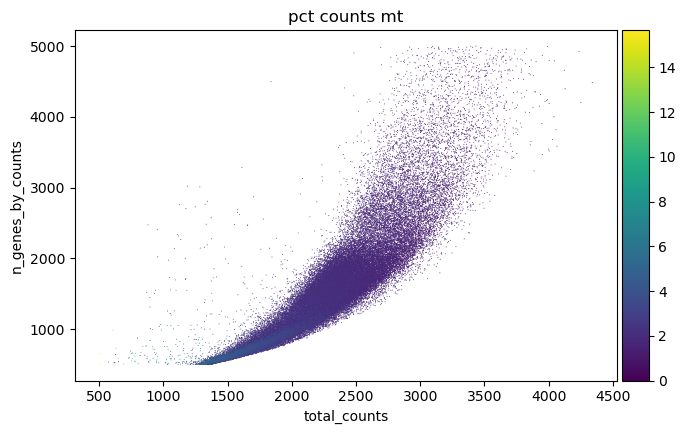

In [34]:
sc.pl.scatter(adata_qc, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Doublet detection

scrublet 사용하여 이중 세포 감지

In [33]:
print(adata_qc.obs.head())

                               n_genes_by_counts  total_counts  \
GSM4952953@AAACGGGCAGCTCGAC-1               1184   1840.053711   
GSM4952953@AAAGCAAAGCGAAGGG-1               1231   1811.295410   
GSM4952953@AAATGCCCAGAGTGTG-1                692   1632.593140   
GSM4952953@AACCATGTCTTGTACT-1               1334   2230.066406   
GSM4952953@AACTCCCTCGAATGGG-1               1126   1897.334229   

                               total_counts_mt  pct_counts_mt  \
GSM4952953@AAACGGGCAGCTCGAC-1        25.442890       1.382725   
GSM4952953@AAAGCAAAGCGAAGGG-1        25.878445       1.428726   
GSM4952953@AAATGCCCAGAGTGTG-1        34.727982       2.127167   
GSM4952953@AACCATGTCTTGTACT-1        34.778809       1.559541   
GSM4952953@AACTCCCTCGAATGGG-1        31.479902       1.659165   

                               total_counts_ribo  pct_counts_ribo  \
GSM4952953@AAACGGGCAGCTCGAC-1         315.272400        17.133869   
GSM4952953@AAAGCAAAGCGAAGGG-1         314.411133        17.358358   
GSM49

In [36]:
# sample columns 생성
adata_qc.obs["sample"] = adata_qc.obs_names.str.split('@').str[0]

# scrublet 실행
sc.pp.scrublet(adata_qc, batch_key='sample')

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [37]:
print(adata_qc.obs[['doublet_score', 'predicted_doublet']].head())

                               doublet_score  predicted_doublet
GSM4952953@AAACGGGCAGCTCGAC-1       0.042383              False
GSM4952953@AAAGCAAAGCGAAGGG-1       0.036959              False
GSM4952953@AAATGCCCAGAGTGTG-1       0.045455              False
GSM4952953@AACCATGTCTTGTACT-1       0.093439              False
GSM4952953@AACTCCCTCGAATGGG-1       0.143662              False


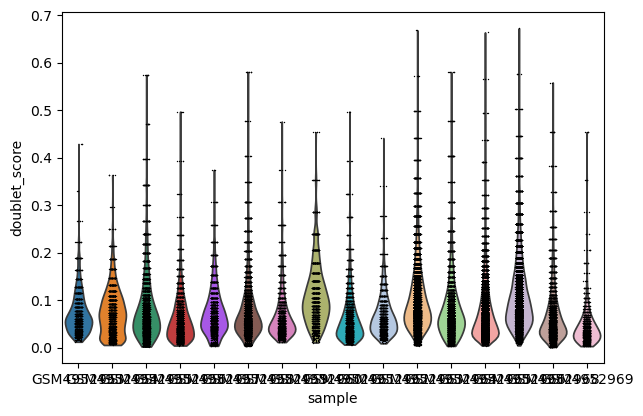

In [39]:
# 4) 시각화
sc.pl.violin(adata_qc, ['doublet_score'], groupby='sample')

원본 데이터를 counts 레이어에 저장.

총 발현량을 정규화 (normalize_total) 하고 로그 변환 (log1p) 수행한다.

In [40]:
adata_qc.layers["counts"] = adata_qc.X.copy()

### Normalization

In [41]:
# total-counts normalization
sc.pp.normalize_total(adata_qc, target_sum = 1e4)

# log 변환
sc.pp.log1p(adata_qc)

In [44]:
sc.pp.highly_variable_genes(adata_qc,
                            min_mean=0.0125,
                            max_mean=3,
                            min_disp=0.5
                            )

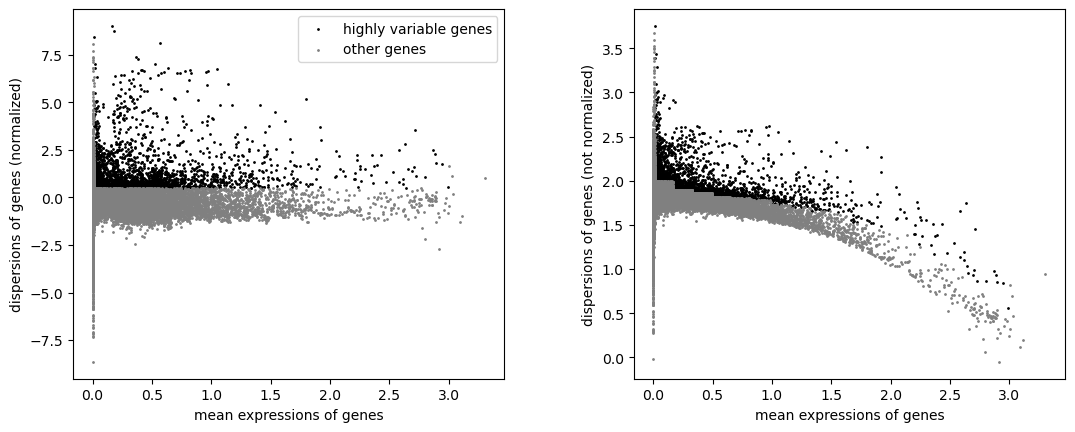

In [45]:
sc.pl.highly_variable_genes(adata_qc)

In [46]:
print(f"HVG 개수 : {adata_qc.var['highly_variable'].sum()}")

HVG 개수 : 2552


HVG 추출 후 PCA 수행

In [47]:
adata_qc = adata_qc[:, adata_qc.var['highly_variable']]

In [48]:
# 유전자별 발현 값이 스케일 차이가 크기 때문에, 평균 0, 분산 1로 맞춰준다.
sc.pp.scale(adata_qc, max_value=10)

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [49]:
sc.tl.pca(adata_qc, svd_solver="arpack")

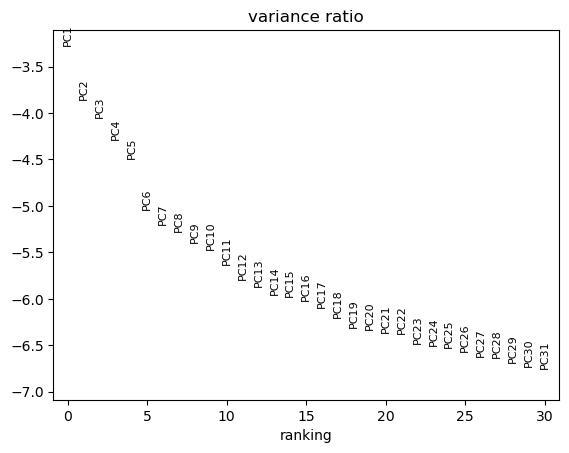

In [50]:
sc.pl.pca_variance_ratio(adata_qc, log=True)

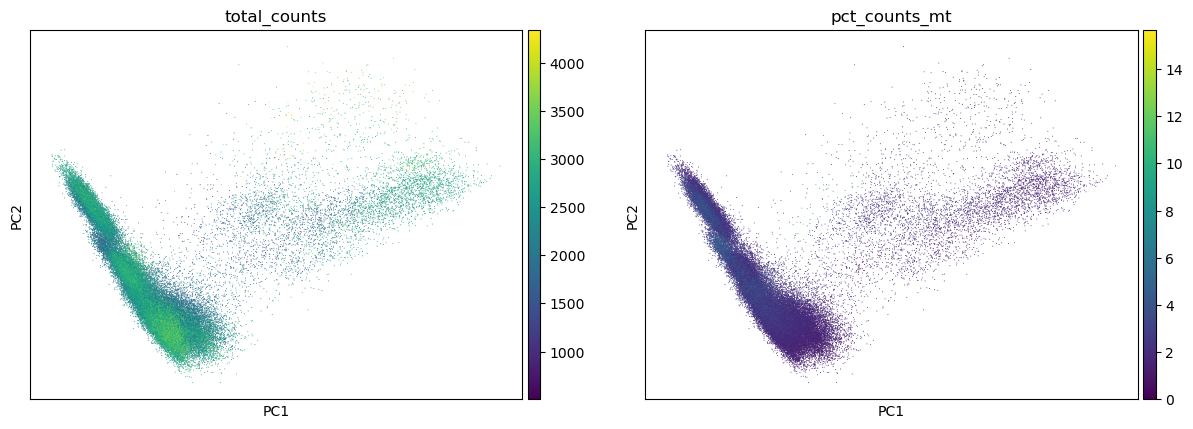

In [52]:
# pca scatter plot
sc.pl.pca(adata_qc, color=['total_counts', 'pct_counts_mt'])

### Nearest neigbor graph construction and visualization

In [53]:
sc.pp.neighbors(adata_qc, n_neighbors=10, n_pcs=40)

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
sc.tl.umap(adata_qc)

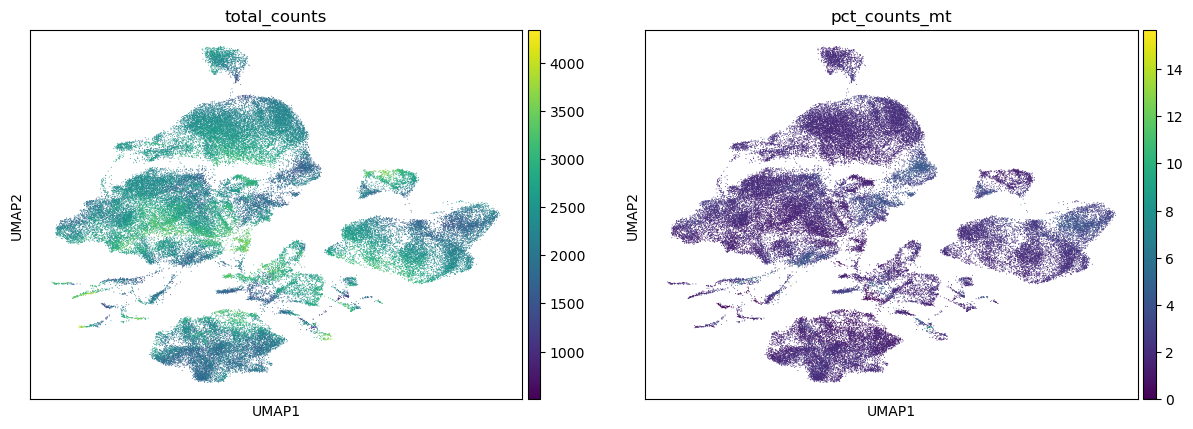

In [57]:
sc.pl.umap(adata_qc, color=['total_counts', 'pct_counts_mt'])

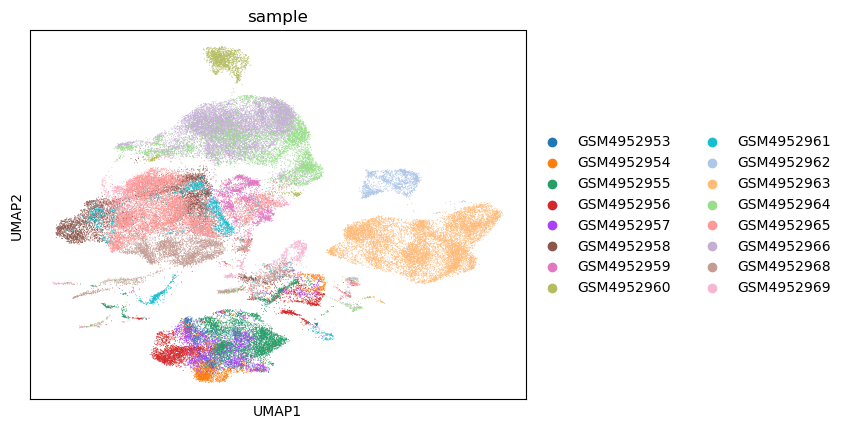

In [55]:
sc.pl.umap(
    adata_qc,
    color=['sample']
)

### Clustering

ledien 알고리즘을 사용하여 클러스터링을 수행하고 결과를 umap에 시각화

In [59]:
# leiden 클러스터링

sc.tl.leiden(adata_qc, resolution=0.5)

/var/folders/m5/z71192pd5msbtxhv764jq3_h0000gn/T/ipykernel_70799/1420486825.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_qc, resolution=0.5)


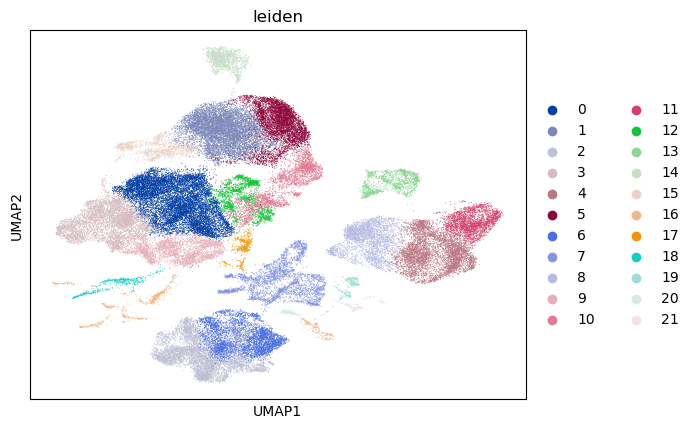

In [60]:
sc.pl.umap(adata_qc, color=['leiden'])